# Chi tiết thuật toán được triển khai

Dưới đây mô tả thuật toán được triển khai trong thư viện này một cách từng bước.

In [1]:
import numpy as np
from scipy.stats import norm, gamma
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import binom  # For binomial coefficient

# Set random seed for reproducibility
np.random.seed(42)

## 1. Load dữ liệu

In [2]:
# Provided Data
ratings = pd.read_csv("../data/processed/ratings.csv", header=None)
defaults = pd.read_csv("../data/processed/defaults.csv", header=None)

# Convert to numpy arrays
n_tk = ratings.values
N_tk = defaults.values

ratings = ['CCC', 'B', 'BB', 'BBB', 'A']
x_t = np.array([2.7, 3.9, 3.1, 2.8, 3.3, 2.7, -2.9, 6.4, 3.2, 2.8])

T, K = N_tk.shape

## 2. Mô tả và thuật toán

In [15]:
def logit(p):
    return 1 / (1 + np.exp(-p))

# Gibbs Sampler for Model 3 with CPO
def Model(N_tk, n_tk, x_t, n_iter=15000, burn_in=0):
    T, K = N_tk.shape

    # Initial values
    mu = np.linspace(-2, -10, K)  # Initial guess reflecting decreasing default probability
    beta = np.random.normal(0, 1, K)  # Initial beta_k guesses
    phi = np.ones(K) * 0.5  # Positive initial phi_k
    alpha = 0.5  # Initial alpha in (-1, 1)
    b = np.random.normal(0, 1, T)  # Initial b with variation
    tau = 100.0  # Prior variance for mu and beta
    eta, v = 2, 1  # Inverse-Gamma parameters for phi_k^2

    # Storage
    mu_trace = np.zeros((n_iter, K))
    beta_trace = np.zeros((n_iter, K))
    phi_trace = np.zeros((n_iter, K))
    alpha_trace = np.zeros(n_iter)
    b_trace = np.zeros((n_iter, T))
    # Storage for likelihoods at each iteration for CPO computation
    likelihood_trace = np.zeros((n_iter, T))  # Log-likelihood for each t

    # Full conditional for mu_k: [mu_k | ·] ∝ Π_t [N_tk | n_tk, b_t, mu_k, beta_k, phi_k] [mu_k]
    # - Likelihood: Product of binomial probabilities over time for rating k
    # - Prior: N(0, tau^2) with ordering constraint mu_1 > mu_2 > ... > mu_K
    def log_full_conditional_mu_k(k, mu_k, beta_k, phi_k, b):
        ll = 0
        for t in range(T):
            p = logit(mu_k - x_t[t] * beta_k - phi_k * b[t])
            ll += N_tk[t, k] * np.log(p + 1e-10) + (n_tk[t, k] - N_tk[t, k]) * np.log(1 - p + 1e-10)
        prior = norm.logpdf(mu_k, 0, tau)
        return ll + prior  # Log-posterior for mu_k

    # Full conditional for beta_k: [beta_k | ·] ∝ Π_t [N_tk | n_tk, b_t, mu_k, beta_k, phi_k] [beta_k]
    # - Likelihood: Product of binomial probabilities over time for rating k
    # - Prior: N(0, tau^2)
    def log_full_conditional_beta_k(k, mu_k, beta_k, phi_k, b):
        ll = 0
        for t in range(T):
            p = logit(mu_k - x_t[t] * beta_k - phi_k * b[t])
            ll += N_tk[t, k] * np.log(p + 1e-10) + (n_tk[t, k] - N_tk[t, k]) * np.log(1 - p + 1e-10)
        prior = norm.logpdf(beta_k, 0, tau)
        return ll + prior  # Log-posterior for beta_k

    # Full conditional for phi_k: [phi_k | ·] ∝ Π_t [N_tk | n_tk, b_t, mu_k, beta_k, phi_k] [phi_k]
    # - Likelihood: Product of binomial probabilities over time for rating k
    # - Prior: phi_k^2 ~ Inverse-Gamma(eta, v), phi_k > 0, so [phi_k] ∝ phi_k^(-2(eta+1)) exp(-v/phi_k^2)
    def log_full_conditional_phi_k(k, mu_k, beta_k, phi_k, b):
        ll = 0
        for t in range(T):
            p = logit(mu_k - x_t[t] * beta_k - phi_k * b[t])
            ll += N_tk[t, k] * np.log(p + 1e-10) + (n_tk[t, k] - N_tk[t, k]) * np.log(1 - p + 1e-10)
        prior = -(eta + 1) * np.log(phi_k**2 + 1e-10) - v / (phi_k**2 + 1e-10) if phi_k > 0 else -np.inf
        return ll + prior  # Log-posterior for phi_k

    # Full conditional for b_t: [b_t | ·] ∝ Π_k [N_tk | n_tk, b_t, mu_k, beta_k, phi_k] [b_t | b_{t-1}, b_{t+1}, alpha]
    # - Likelihood: Product of binomial probabilities over all ratings k at time t
    # - Prior: AR(1) process with innovation variance 1
    #   - For t = 0: b_0 ~ N(0, 1/(1-alpha^2)), contributes to b_1 ~ N(alpha b_0, 1)
    #   - For t = 1, ..., T-2: [b_t | b_{t-1}, b_{t+1}, alpha] ~ N(α (b_{t-1} + b_{t+1}) / (1 + α^2), 1 / (1 + α^2))
    #     - Derived from b_t = α b_{t-1} + ε_t and b_{t+1} = α b_t + ε_{t+1}, ε_t, ε_{t+1} ~ N(0, 1)
    #     - The mean α (b_{t-1} + b_{t+1}) / (1 + α^2) balances past and future, variance 1 / (1 + α^2) reflects correlation
    #   - For t = T-1: b_{T-1} ~ N(α b_{T-2}, 1), no future term
    def log_full_conditional_b_t(t, b_t, mu, beta, phi, b_prev, b_next, alpha):
        # Likelihood contribution from observed defaults
        ll = 0
        for k in range(K):
            p = logit(mu[k] - x_t[t] * beta[k] - phi[k] * b_t)
            ll += N_tk[t, k] * np.log(p + 1e-10) + (n_tk[t, k] - N_tk[t, k]) * np.log(1 - p + 1e-10)

        # Prior contribution from AR(1) process
        if t == 0:
            # Initial condition: b_0 affects b_1
            prior = norm.logpdf(b_t, 0, 1 / np.sqrt(1 - alpha**2 + 1e-10)) + \
                    norm.logpdf(b_next, alpha * b_t, 1)
        elif t == T-1:
            # Terminal condition: only depends on b_{T-1}
            prior = norm.logpdf(b_t, alpha * b_prev, 1)
        else:
            # Interior points: b_t conditioned on b_{t-1} and b_{t+1}
            # Explicitly follows [b_t | b_{t-1}, b_{t+1}, α] ~ N(α (b_{t-1} + b_{t+1}) / (1 + α^2), 1 / (1 + α^2))
            mean_prior = alpha * (b_prev + b_next) / (1 + alpha**2 + 1e-10)
            var_prior = 1 / (1 + alpha**2 + 1e-10)
            prior = norm.logpdf(b_t, mean_prior, np.sqrt(var_prior))

        return ll + prior  # Log-posterior for b_t

    # Full conditional for alpha: [alpha | ·] ∝ [b | alpha] [alpha]
    # - Likelihood: Multivariate normal for b with AR(1) covariance
    # - Prior: Uniform(-1, 1)
    def log_full_conditional_alpha(b, alpha):
        if not (-1 < alpha < 1):
            return -np.inf
        Sigma_inv = np.zeros((T, T))
        for i in range(T):
            Sigma_inv[i, i] = 1 + alpha**2 if 0 < i < T-1 else 1
            if i < T-1:
                Sigma_inv[i, i+1] = Sigma_inv[i+1, i] = -alpha
        det_Sigma_inv = (1 - alpha**2 + 1e-10)  # Simplified determinant for AR(1)
        ll = 0.5 * np.log(det_Sigma_inv) - 0.5 * b @ Sigma_inv @ b
        prior = 0  # Uniform(-1, 1) contributes 0 to log (constant)
        return ll + prior  # Log-posterior for alpha

    # Function to compute log-likelihood for a single time period t
    # - Used for CPO: log P(N_t | mu, beta, phi, b_t)
    def log_likelihood_t(t, mu, beta, phi, b_t):
        ll = 0
        for k in range(K):
            p = logit(mu[k] - x_t[t] * beta[k] - phi[k] * b_t)
            ll += np.log(binom(n_tk[t, k], N_tk[t, k]) + 1e-10) + \
                  N_tk[t, k] * np.log(p + 1e-10) + \
                  (n_tk[t, k] - N_tk[t, k]) * np.log(1 - p + 1e-10)
        return ll

    for it in range(n_iter):
        # Update mu_k with Metropolis-Hastings
        for k in range(K):
            mu_prop = mu[k] + np.random.normal(0, 0.5)  # Proposal step
            mu_temp = mu.copy()
            mu_temp[k] = mu_prop
            if all(mu_temp[j] > mu_temp[j+1] for j in range(K-1)):  # Enforce ordering
                log_ratio = log_full_conditional_mu_k(k, mu_prop, beta[k], phi[k], b) - \
                            log_full_conditional_mu_k(k, mu[k], beta[k], phi[k], b)
                if np.isfinite(log_ratio) and np.log(np.random.rand()) < log_ratio:
                    mu[k] = mu_prop

        # Update beta_k with Metropolis-Hastings
        for k in range(K):
            beta_prop = beta[k] + np.random.normal(0, 0.5)
            log_ratio = log_full_conditional_beta_k(k, mu[k], beta_prop, phi[k], b) - \
                        log_full_conditional_beta_k(k, mu[k], beta[k], phi[k], b)
            if np.isfinite(log_ratio) and np.log(np.random.rand()) < log_ratio:
                beta[k] = beta_prop

        # Update phi_k with Metropolis-Hastings
        for k in range(K):
            phi_prop = phi[k] + np.random.normal(0, 0.5)
            if phi_prop > 0:  # Enforce positivity
                log_ratio = log_full_conditional_phi_k(k, mu[k], beta[k], phi_prop, b) - \
                            log_full_conditional_phi_k(k, mu[k], beta[k], phi[k], b)
                if np.isfinite(log_ratio) and np.log(np.random.rand()) < log_ratio:
                    phi[k] = phi_prop

        # Update b_t with Metropolis-Hastings
        for t in range(T):
            b_prev = b[t-1] if t > 0 else 0
            b_next = b[t+1] if t < T-1 else 0
            b_prop = b[t] + np.random.normal(0, 0.5)  # Random-walk proposal
            log_ratio = log_full_conditional_b_t(t, b_prop, mu, beta, phi, b_prev, b_next, alpha) - \
                        log_full_conditional_b_t(t, b[t], mu, beta, phi, b_prev, b_next, alpha)
            if np.isfinite(log_ratio) and np.log(np.random.rand()) < log_ratio:
                b[t] = b_prop

        # Update alpha with Metropolis-Hastings
        alpha_prop = alpha + np.random.normal(0, 0.5)  # Normal proposal centered at current alpha
        if -1 < alpha_prop < 1:  # Check bounds
            log_ratio = log_full_conditional_alpha(b, alpha_prop) - log_full_conditional_alpha(b, alpha)
            if np.isfinite(log_ratio) and np.log(np.random.rand()) < log_ratio:
                alpha = alpha_prop

        # Store results
        mu_trace[it] = mu
        beta_trace[it] = beta
        phi_trace[it] = phi
        alpha_trace[it] = alpha
        b_trace[it] = b

        # Compute and store log-likelihood for each t for CPO
        for t in range(T):
            likelihood_trace[it, t] = log_likelihood_t(t, mu, beta, phi, b[t])

    # CPO computation using harmonic mean estimator
    # - For each t, CPO_t ≈ 1 / (1/N * Σ (1/P(N_t | θ^(i))))
    # - Where θ^(i) is the i-th MCMC sample, N is post-burn-in iterations
    post_burn_in = n_iter - burn_in
    log_cpo_t = np.zeros(T)
    for t in range(T):
        # Harmonic mean of inverse likelihoods
        inv_likelihood = 1 / (np.exp(likelihood_trace[burn_in:, t]) + 1e-10)
        mean_inv_likelihood = np.mean(inv_likelihood)
        log_cpo_t[t] = -np.log(mean_inv_likelihood + 1e-10)  # log(CPO_t)

    # Summary statistics for model comparison
    avg_log_cpo = np.mean(log_cpo_t)  # Average log(CPO) across all t
    sum_log_cpo = np.sum(log_cpo_t)   # Sum of log(CPO) for overall fit

    return {
        'mu': mu_trace[burn_in:],
        'beta': beta_trace[burn_in:],
        'phi': phi_trace[burn_in:],
        'alpha': alpha_trace[burn_in:],
        'b': b_trace[burn_in:],
        'log_cpo_t': log_cpo_t,       # Log(CPO) for each t
        'avg_log_cpo': avg_log_cpo,   # Average log(CPO)
        'sum_log_cpo': sum_log_cpo    # Sum of log(CPO)
    }

## 3. Chạy thực nghiệm và kết quả

In [22]:
# Set random seed for reproducibility
np.random.seed(42)

# Run Model
results = Model(N_tk, n_tk, x_t)

Model Estimates:
Mean:
mu: [ -0.56992402  -3.73157098  -5.57410889  -8.93002817 -88.89831152]
beta: [ 0.20219716  0.19841525  0.36543399 -0.04114798  4.73575064]
phi: [0.50372018 0.67763239 0.68544338 0.72181215 0.74667647]
alpha: -0.11772611525200771
----------------------------------------------------------------------------------------------------
Standard Deviation:
mu: [ 0.28712221  0.36790329  0.44231527  1.03059121 15.23593937]
beta: [0.07633894 0.10202826 0.1306199  0.28786331 7.13400201]
phi: [0.09667645 0.13405323 0.20113725 0.23599344 0.31296959]
alpha: 0.4013490715017677
----------------------------------------------------------------------------------------------------
Average Log(CPO): -15.528719734369153


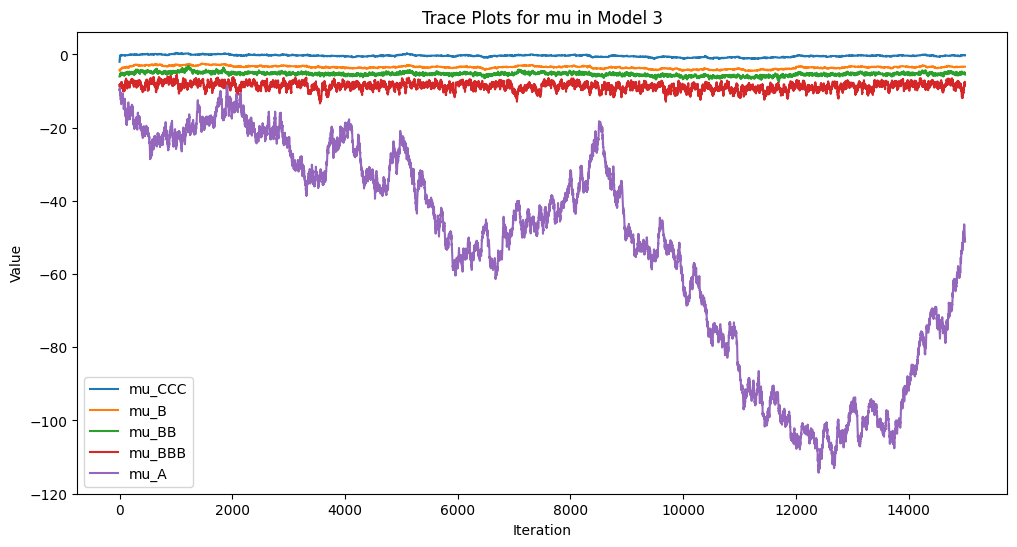

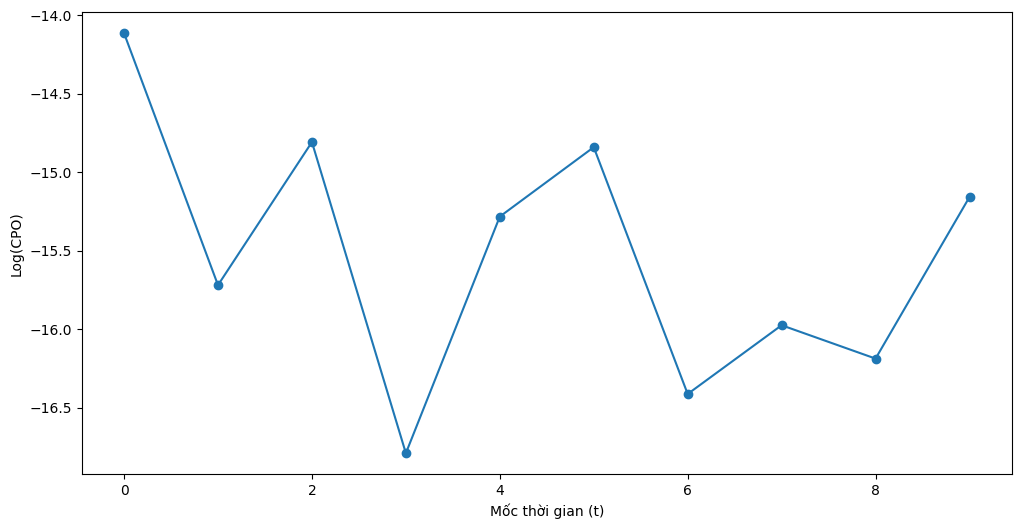

In [25]:
print("Model Estimates:")
print("Mean:") # Mean 
print("mu:", np.mean(results['mu'][10000:15000, :], axis=0))
print("beta:", np.mean(results['beta'][10000:15000, :], axis=0))
print("phi:", np.mean(results['phi'][10000:15000, :], axis=0))
print("alpha:", np.mean(results['alpha'][10000:15000]))


print("-" * 100) # Standard Deviation:
print("Standard Deviation:")
print("mu:", np.std(results['mu'][10000:15000, :], axis=0))
print("beta:", np.std(results['beta'][10000:15000, :], axis=0))
print("phi:", np.std(results['phi'][10000:15000, :], axis=0))
print("alpha:", np.std(results['alpha'][10000:15000]))

print("-" * 100)
print("Average Log(CPO):", results['avg_log_cpo'])

# Plot mu traces to check convergence
plt.figure(figsize=(12, 6))
for k in range(K):
    plt.plot(results['mu'][:, k], label=f'mu_{ratings[k]}')
plt.legend()
plt.title('Trace Plots for mu in Model 3')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.show()

# Plot log(CPO) for each time period
plt.figure(figsize=(12, 6))
plt.plot(range(T), results['log_cpo_t'], marker='o')
# plt.title('Log(CPO) for Each Time Period')
plt.xlabel('Mốc thời gian (t)')
plt.ylabel('Log(CPO)')
plt.show()

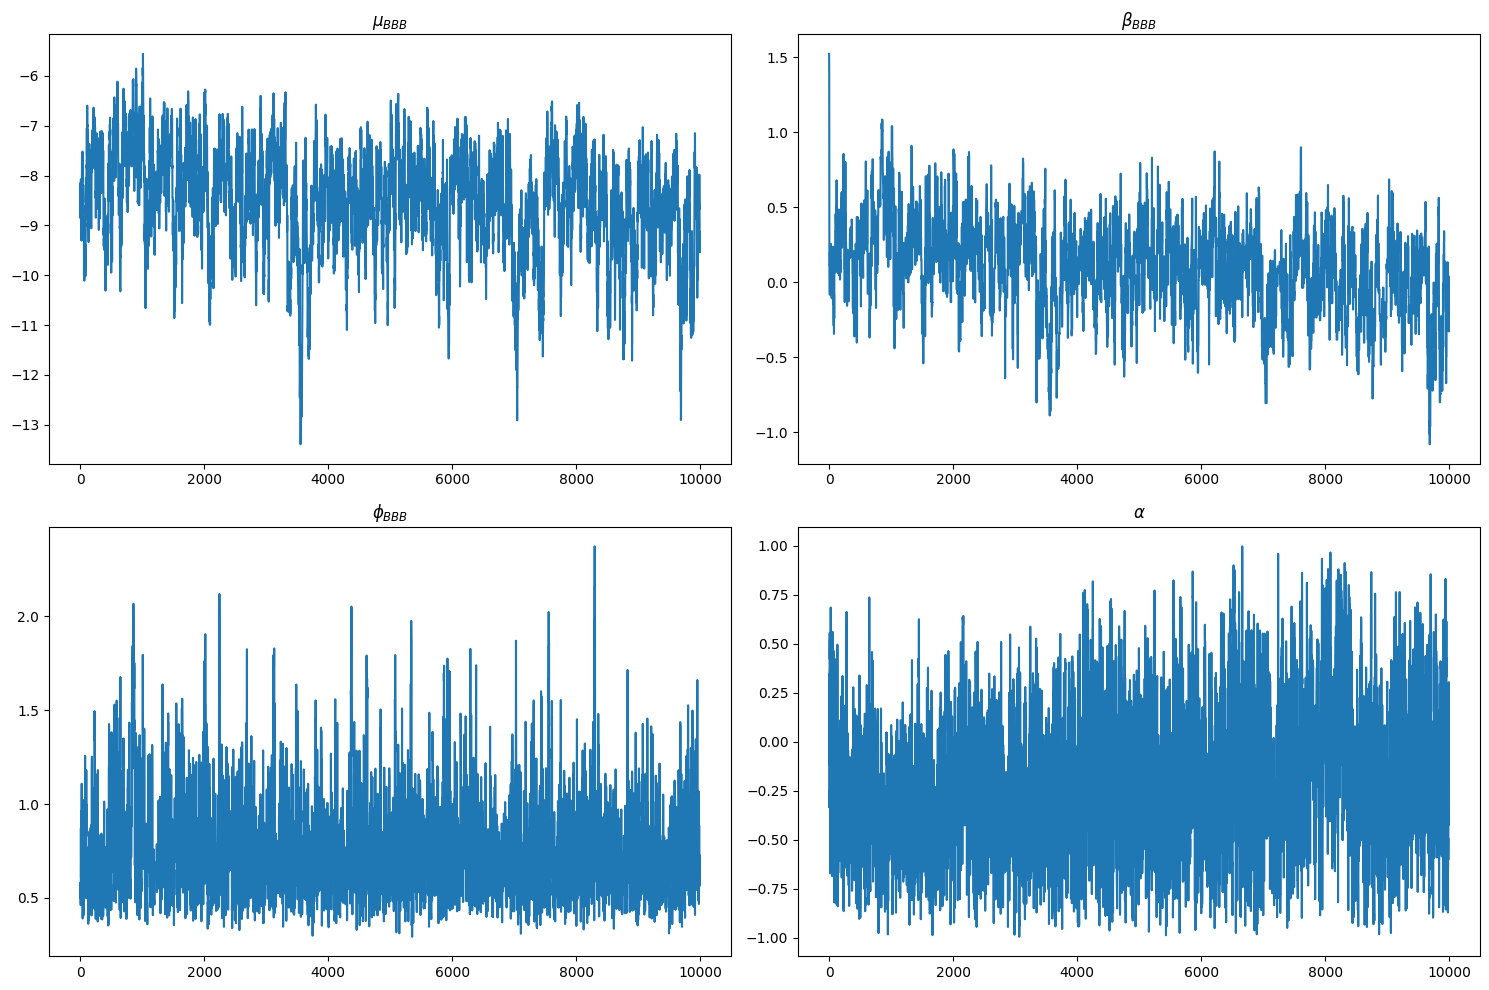

In [24]:
# Visualization
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
for k in [3]:
    plt.plot(results['mu'][:10000, k])
plt.title(r'$\mu_{BBB}$')

plt.subplot(2, 2, 2)
for k in [3]:
    plt.plot(results['beta'][:10000, k])
plt.title(r'$\beta_{BBB}$')

plt.subplot(2, 2, 3)
for k in [3]:
    plt.plot(results['phi'][:10000, k])

plt.title(r'$\phi_{BBB}$')

plt.subplot(2, 2, 4)
plt.plot(results['alpha'][:10000])
plt.title(r'$\alpha$')
plt.tight_layout()
plt.show()

## 4. Một cách chạy khác thông qua thư viện đã được nhóm xây dựng

In [4]:
from glmm import OrderedBinomialGLMM

# Initialize and fit model
model = OrderedBinomialGLMM(
    n_iter=15000,
    burn_in=5000,
    tau=100.0,
    eta=2.0,
    v=1.0,
    random_seed=42
)

print("\nFitting model...")
traces = model.fit(N_tk, n_tk, x_t)
estimates = model.get_estimates()


Fitting model...


In [6]:
# Print parameter estimates
print("\nParameter Estimates:")
print("-" * 50)

# Mu (ordered intercepts)
print("\nOrdered Intercepts (mu):")
for k, label in enumerate(ratings):
    mean = estimates['mu']['mean'][k]
    std = np.sqrt(estimates['mu']['variance'][k])
    print(f"{label:4s}: {mean:6.3f} ± {std:5.3f}")

# Beta (rating-specific slopes)
print("\nRating-specific Slopes (beta):")
for k, label in enumerate(ratings):
    mean = estimates['beta']['mean'][k]
    std = np.sqrt(estimates['beta']['variance'][k])
    print(f"{label:4s}: {mean:6.3f} ± {std:5.3f}")

# Phi (rating-specific loadings)
print("\nRating-specific Loadings (phi):")
for k, label in enumerate(ratings):
    mean = estimates['phi']['mean'][k]
    std = np.sqrt(estimates['phi']['variance'][k])
    print(f"{label:4s}: {mean:6.3f} ± {std:5.3f}")

# Alpha (AR(1) coefficient)
alpha_mean = estimates['alpha']['mean']
alpha_std = np.sqrt(estimates['alpha']['variance'])
print(f"\nAR(1) coefficient (alpha): {alpha_mean:.3f} ± {alpha_std:.3f}")


Parameter Estimates:
--------------------------------------------------

Ordered Intercepts (mu):
CCC : -0.485 ± 0.277
B   : -3.627 ± 0.351
BB  : -5.456 ± 0.430
BBB : -8.823 ± 1.023
A   : -66.833 ± 25.468

Rating-specific Slopes (beta):
CCC :  0.226 ± 0.075
B   :  0.227 ± 0.097
BB  :  0.404 ± 0.135
BBB : -0.011 ± 0.290
A   :  4.165 ± 6.613

Rating-specific Loadings (phi):
CCC :  0.504 ± 0.102
B   :  0.674 ± 0.137
BB  :  0.704 ± 0.221
BBB :  0.732 ± 0.249
A   :  0.745 ± 0.312

AR(1) coefficient (alpha): -0.137 ± 0.397
